In [171]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
%matplotlib inline

#### Preparing data...

In [33]:
def read_file(filepath):
    with open(filepath) as f:
        reviews = f.read()
        reviews = reviews.split('\n')
        tokenized = map(lambda x: x.split(), reviews)
    return list(tokenized)

In [34]:
def split_vals(reviews ,perc): 
    n = int(len(reviews)*perc)
    return reviews[:n], reviews[n:]

In [35]:
reviews_pos = read_file('positive_reviews.txt')

In [36]:
reviews_neg = read_file('negative_reviews.txt')

In [6]:
pos_test, pos_train = split_vals(reviews_pos, .20)

In [7]:
neg_test, neg_train = split_vals(reviews_neg, .20)

In [8]:
unsup = read_file('unsupervised_reviews.txt')

In [12]:
def generate_w2v(tokens):
    """
    Given a set of tokenized reviews, trains word2vec model.
    :param tokens: Corpus of reviews, broken down into tokens for each review.
    :return: Trained Word2Vec model.
    """
    w2v_model = Word2Vec(size=100, window=10, min_count=5, workers=8,
                         alpha=0.025, min_alpha=0.025)
    w2v_model.build_vocab(tokens)
    for epoch in range(10):
        print("Iteration nb", epoch)
        w2v_model.train(tokens, total_examples=w2v_model.corpus_count,
                        epochs=w2v_model.iter)
        w2v_model.alpha -= 0.001  # decrease the learning rate
        w2v_model.min_alpha = w2v_model.alpha
    return w2v_model

In [13]:
all_reviews = pos_train + neg_train + unsup

#### Training Word2Vec

In [14]:
w2v = generate_w2v(all_reviews)

Iteration nb 0


/Users/Nicha/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  del sys.path[0]


Iteration nb 1
Iteration nb 2
Iteration nb 3
Iteration nb 4
Iteration nb 5
Iteration nb 6
Iteration nb 7
Iteration nb 8
Iteration nb 9


#### Checking to see that word embeddings make sense...

In [70]:
w2v.most_similar('typical')

/Users/Nicha/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('standard', 0.6307519674301147),
 ('generic', 0.5929383039474487),
 ('usual', 0.5681242346763611),
 ('ish', 0.5674628019332886),
 ('stereotypical', 0.5471631288528442),
 ('type', 0.5376464128494263),
 ('typically', 0.5306581854820251),
 ('mainstay', 0.527876615524292),
 ('mill', 0.49052008986473083),
 ('oriented', 0.48973286151885986)]

In [16]:
w2v.most_similar('bad')

/Users/Nicha/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('lousy', 0.7388101816177368),
 ('terrible', 0.7335008382797241),
 ('good', 0.7166964411735535),
 ('horrible', 0.713603138923645),
 ('awful', 0.6747781038284302),
 ('crappy', 0.6741146445274353),
 ('poor', 0.6500096321105957),
 ('dumb', 0.6295918226242065),
 ('stupid', 0.6238218545913696),
 ('lame', 0.5957022309303284)]

In [17]:
from nltk.corpus import stopwords

In [18]:
stopWords = set(stopwords.words('english'))

In [19]:
def get_non_stopwords(tokens, stopwords):
    """Returns a list of non-stopwords"""
    return [x for x in tokens if x not in stopwords]

In [20]:
def sentence_features(review, w2v_model=w2v, emb_size=100):
    words = get_non_stopwords(review, stopWords)
    words = [w for w in words if w.isalpha() and w in w2v]
    if len(words) == 0:
        return [np.zeros(emb_size)]
    M = np.array([w2v[w] for w in words])
    return list(M.mean(axis=0))

#### Building features...

In [71]:
X_train = pd.DataFrame(list(map(lambda x: sentence_features(x, w2v), pos_train + neg_train)))
y_train = [1] * len(pos_train) + [0] * len(neg_train)

/Users/Nicha/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Nicha/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [72]:
X_test = pd.DataFrame(list(map(lambda x: sentence_features(x, w2v), pos_test + neg_test)))
y_test = [1] * len(pos_test) + [0] * len(neg_test)

/Users/Nicha/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Nicha/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


#### Trying different models...

In [94]:
from sklearn import svm

In [95]:
lin_svm = svm.LinearSVC()
lin_svm.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [96]:
lin_svm.score(X_test, y_test)

0.85009999999999997

In [110]:
from sklearn.naive_bayes import GaussianNB

In [111]:
nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB(priors=None)

In [113]:
nb.score(X_test,y_test)

0.73009999999999997

In [ ]:
from sklearn.linear_model import LogisticRegression

In [98]:
logisticRegr = LogisticRegression(C=0.1)

In [99]:
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [100]:
logisticRegr.score(X_test, y_test)

0.85160000000000002

#### Hyperparameter tuning for Logistics Regression...

In [97]:
for i in [0.1, 0.2, 0.3, 0.5, 1.0, 1.1, 1.2, 1.5]:
    logisticRegr = LogisticRegression(C=i)
    logisticRegr.fit(X_train, y_train)
    print(logisticRegr.score(X_test, y_test))

0.8516
0.8509
0.851
0.8507
0.8507
0.8507
0.8506
0.8505


#### Keyword Analysis...

In [126]:
from collections import Counter

In [138]:
from wordcloud import WordCloud

In [129]:
token_freq = Counter([item for sublist in all_reviews for item in sublist])

In [130]:
scores = []
for i in list(w2v.wv.vocab):
    scores.append((i, logisticRegr.predict_proba([w2v[i]])[0][1], token_freq[i]))

/Users/Nicha/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [131]:
scores_df = pd.DataFrame(scores, columns = ['keyword', 'positive_probability', 'freq'])

In [140]:
# positive words are those w/ embeddings that logistics regression point out to 100% positive probability
pos_words = scores_df[scores_df.positive_probability == 1].sort_values(by='freq', ascending=False)[['keyword', 'freq']]

#### Create Word Clouds weighing by term frequency...

In [176]:
pos_wc = WordCloud(background_color='white').generate_from_frequencies(dict(tuple(x) for x in pos_words.values))

(-0.5, 399.5, 199.5, -0.5)

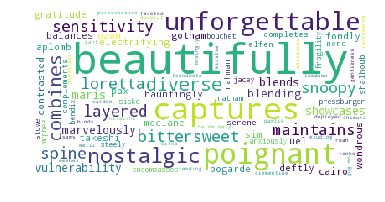

In [178]:
plt.imshow(pos_wc)
plt.axis('off')

We can see that keywords with embeddings that point out to positive sentiment tend to be those that show the emotions that the movie evoked or the art of the film (e.g. combines, blend, maintains, beautifully, captures..etc).

In [182]:
# negative words are those w/ embeddings that logistics regression point out close to 0% positive probability
neg_words = scores_df.sort_values(by='positive_probability')[:100][['keyword', 'freq']]

In [183]:
neg_wc = WordCloud(background_color='white').generate_from_frequencies(dict(tuple(x) for x in neg_words.values))

(-0.5, 399.5, 199.5, -0.5)

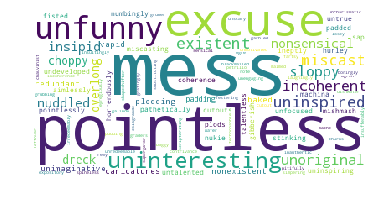

In [184]:
plt.imshow(neg_wc)
plt.axis('off')

We can see that keywords with embeddings that point out to negative sentiment are those that tend to show how the film failed to evoke a clear interest or profound emotions.